In [2]:
# %pip install mlforecast polars statsforecast

In [3]:
import mlforecast
import polars as pl
from datetime import datetime
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    AutoCES
)
import importlib
import fx_rl
importlib.reload(fx_rl)
from utilsforecast.losses import mse, rmse
from utilsforecast.evaluation import evaluate

In [4]:
# pd_df = pd.read_csv('EURUSD_full_tickstory_data_hourly.csv')
# pd_df.loc[:, 'EURUSD'] = 'EURUSD'
# pd_df['Time'] = pd.to_datetime(pd_df['Time'])
# pd_df = pd_df.rename(columns={
#     'Close': 'y',
#     'Time': 'ds',
#     'EURUSD': 'unique_id'
# })

In [45]:
df = (
    pl.scan_csv('EURUSD_full_tickstory_data_hourly.csv')
    # convert 'Time' to datetime
    .with_columns([
        # add a unique_id col which will be 'EURUSD' as a string
        pl.lit('EURUSD').alias('unique_id').cast(pl.Utf8),
        pl.col('Time').alias('ds').str.to_datetime(format='%Y-%m-%d %H:%M:%S+00:00'),
        # .dt.replace_time_zone('UTC'),
        pl.col('Close').alias('y').cast(pl.Float64)       
    ])
    # .filter(pl.col('ds') >= pl.date(2023, 1, 1))
    # sort by 'Date'
   .sort('ds')
   .select(pl.col('unique_id', 'ds', 'y'))
    ).collect()
df

unique_id,ds,y
str,datetime[μs],f64
"""EURUSD""",2016-08-01 03:00:00,1.1175
"""EURUSD""",2016-08-01 04:00:00,1.11719
"""EURUSD""",2016-08-01 05:00:00,1.11709
"""EURUSD""",2016-08-01 06:00:00,1.11785
"""EURUSD""",2016-08-01 07:00:00,1.11794
…,…,…
"""EURUSD""",2024-08-09 19:00:00,1.09186
"""EURUSD""",2024-08-09 20:00:00,1.09206
"""EURUSD""",2024-08-09 21:00:00,1.09195


In [46]:
# https://www.fxstreet.com/economic-calendar
news_data_full = (
    pl.scan_csv('calendar_df_full_updated.csv')
    .with_columns([
        pl.col('datetime').str.to_datetime(),
    ])
    .select('Id', 'datetime')
).collect()
max_news_date = news_data_full.select(pl.col('datetime').max()).item()
news_data = (
    pl.scan_csv('calendar-event-list.csv')
    .with_columns([
        pl.col('Start').alias('datetime').str.to_datetime(format='%m/%d/%Y %H:%M:%S').dt.offset_by('7h'),
    ])
    .select('Id', 'datetime')
).collect()
max_new_news_date = news_data.select(pl.col('datetime').max()).item()
if max_news_date < max_new_news_date:
    # concatenate the news data with news_data_full
    print('adding latest data')
    news_data_full = pl.concat([news_data_full, news_data])
    news_data_full.write_csv('calendar_df_full_updated.csv')
# news_data_full

In [47]:
# Assuming you have two DataFrames:
# df: Your main DataFrame with the 'ds' column
# news_counts: DataFrame with news events and their datetimes

# group news_data_full by 'ds' and count the number of 'Id' rows
news_counts = news_data_full.group_by('datetime').len().sort(by='datetime')

def find_seconds_to_next_news(df, news_counts):
    # Ensure both DataFrames have their time columns as datetime
    df = df.with_columns(pl.col("ds").cast(pl.Datetime))
    news_counts = news_counts.with_columns(pl.col("datetime").cast(pl.Datetime))

    # Combine both DataFrames
    combined = pl.concat([
        df.select(pl.col("ds").alias("time")).with_columns(pl.lit("main").alias("source")),
        news_counts.select(pl.col("datetime").alias("time")).with_columns(pl.lit("news").alias("source"))
    ])

    # Sort by time, source, time ascending, source descending
    combined = combined.sort(["time", "source"], descending=[False, True])

    # Find the next news event for each row
    result = combined.with_columns([
        pl.when(pl.col("source") == "news")
        .then(pl.col("time"))
        .otherwise(None)
        .forward_fill()
        .alias("prev_news_time"),
        pl.when(pl.col("source") == "news")
        .then(pl.col("time"))
        .otherwise(None)
        .backward_fill()
        .alias("next_news_time"),
        pl.col("source")
    ])

    # Calculate the time difference for main events
    result = result.filter(pl.col("source") == "main").with_columns([
        pl.col('time').dt.week().alias('time_week_nbr'),
        pl.col('prev_news_time').dt.week().alias('prev_time_week_nbr'),
        pl.col('next_news_time').dt.week().alias('next_time_week_nbr'),
        (
            pl.when(
                (pl.col("time").dt.week() != pl.col("prev_news_time").dt.week())
            )
            .then((pl.col("prev_news_time") - pl.col("time")).dt.total_seconds() + (2 * 86400))
            .otherwise((pl.col("prev_news_time") - pl.col("time")).dt.total_seconds())
        ).alias("seconds_since_last_news_event"),
        # get the week number for "time"
        

        (
            pl.when(
                (pl.col("time").dt.week() != pl.col("next_news_time").dt.week())
            )
            .then((pl.col("next_news_time") - pl.col("time")).dt.total_seconds() - (2 * 86400))
            .otherwise((pl.col("next_news_time") - pl.col("time")).dt.total_seconds())
        ).alias("seconds_to_next_news_event")
    ])


    # Join the result back to the original DataFrame
    final_df = df.join(
        result.select(pl.col("time").alias("ds"), "seconds_since_last_news_event", "seconds_to_next_news_event"), 
        on="ds", 
        how="left"
    )

    return final_df

# Usage
df_w_news = find_seconds_to_next_news(df, news_counts)
df_w_news

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event
str,datetime[μs],f64,i64,i64
"""EURUSD""",2016-08-01 03:00:00,1.1175,-14400,50400
"""EURUSD""",2016-08-01 04:00:00,1.11719,-18000,46800
"""EURUSD""",2016-08-01 05:00:00,1.11709,-21600,43200
"""EURUSD""",2016-08-01 06:00:00,1.11785,-25200,39600
"""EURUSD""",2016-08-01 07:00:00,1.11794,-28800,36000
…,…,…,…,…
"""EURUSD""",2024-08-09 19:00:00,1.09186,-284400,160200
"""EURUSD""",2024-08-09 20:00:00,1.09206,-288000,156600
"""EURUSD""",2024-08-09 21:00:00,1.09195,-291600,153000


In [48]:
# rename the 'ds' column 'Datetime' and create a new 'ds' column that is the row number
df_w_news_new_ds = df_w_news.with_columns([
    pl.col('ds').alias('Datetime'),
    pl.arange(0, df_w_news.height).alias('ds')
])
df_w_news_new_ds

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event,Datetime
str,i64,f64,i64,i64,datetime[μs]
"""EURUSD""",0,1.1175,-14400,50400,2016-08-01 03:00:00
"""EURUSD""",1,1.11719,-18000,46800,2016-08-01 04:00:00
"""EURUSD""",2,1.11709,-21600,43200,2016-08-01 05:00:00
"""EURUSD""",3,1.11785,-25200,39600,2016-08-01 06:00:00
"""EURUSD""",4,1.11794,-28800,36000,2016-08-01 07:00:00
…,…,…,…,…,…
"""EURUSD""",50081,1.09186,-284400,160200,2024-08-09 19:00:00
"""EURUSD""",50082,1.09206,-288000,156600,2024-08-09 20:00:00
"""EURUSD""",50083,1.09195,-291600,153000,2024-08-09 21:00:00


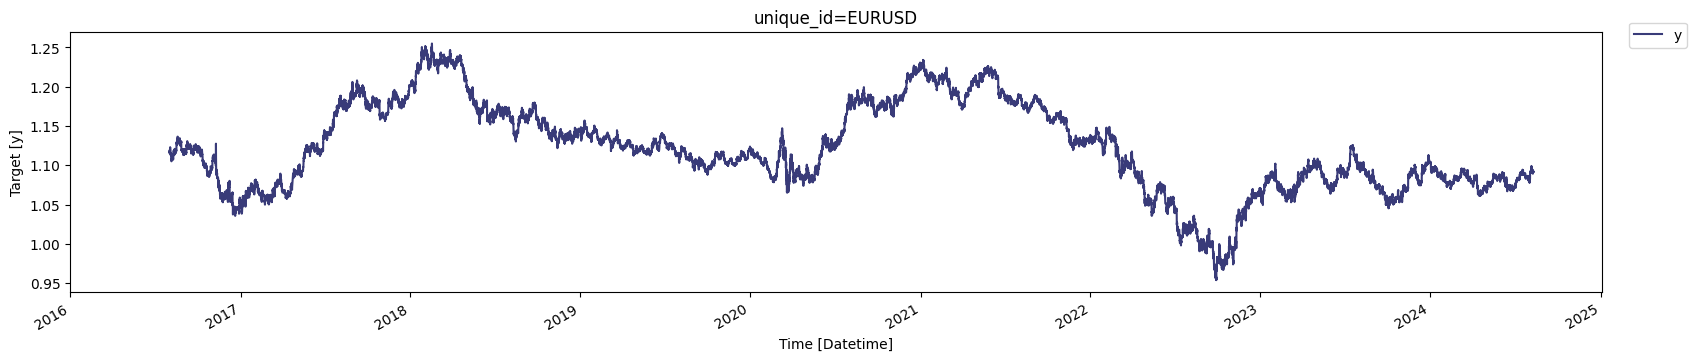

In [49]:
StatsForecast.plot(df_w_news_new_ds, time_col='Datetime')

In [50]:
# # Create a list of models and instantiation parameters
# models = [
#     AutoARIMA(),
#     HoltWinters(),
#     SeasonalNaive(season_length=7),
#     DOT(season_length=24),
#     AutoCES(),
#     AutoETS()
# ]
# # Instantiate StatsForecast class as sf
# sf = StatsForecast( 
#     models=models,
#     freq=1, 
#     n_jobs=-1,
#     fallback_model=SeasonalNaive(season_length=7),
#     verbose=True
# )


In [51]:
# forecasts_df = sf.forecast(df=df, h=48, level=[90])
# forecasts_df.head()


In [52]:
# # remove the 'HistoricAverage', 'HistoricAverage-lo-90', and 'HistoricAverage-hi-90'
# rm_cols = ['HistoricAverage', 'HistoricAverage-lo-90', 'HistoricAverage-hi-90']
# cols = [col for col in forecasts_df.columns if col not in rm_cols]
# forecasts_df_sel = forecasts_df.loc[:, cols]

In [53]:
# sf.plot(pd_df[(pd_df['ds'].dt.year >= 2024) & 
#               (pd_df['ds'].dt.month >= 8) & 
#               (pd_df['ds'].dt.day >= 8)], forecasts_df=forecasts_df_sel, models=['CrostonClassic', 'SeasonalNaive'], id_col='unique_id', time_col='ds', target_col='y')

# len(pd_df[(pd_df['ds'].dt.year >= 2024) & 
#               (pd_df['ds'].dt.month >= 1)])
# crossvaldation_df = sf.cross_validation(
#     df=df,
#     h=5,
#     step_size=5,
#     n_windows=3
# )
# crossvaldation_df

In [54]:
# def evaluate_cross_validation_polars(df, metric):
#     models = [c for c in df.columns if c not in ('unique_id', 'ds', 'cutoff', 'y')]
#     evals = []
#     # Calculate loss for every unique_id and cutoff.    
#     for cutoff in df['cutoff'].unique():
#         eval_ = evaluate(df.filter(pl.col('cutoff') == cutoff), metrics=[metric], models=models)
#         evals.append(eval_)
#     evals = pl.concat(evals).drop('metric')
#     # Calculate the mean of each 'unique_id' group
#     evals = evals.group_by(['unique_id'], maintain_order=True).mean() 

#     # For each row in evals (excluding 'unique_id'), find the model with the lowest value
#     best_model = [min(row, key=row.get) for row in evals.drop('unique_id').rows(named=True)]

#     # Add a 'best_model' column to evals dataframe with the best model for each 'unique_id'
#     evals = evals.with_columns(pl.Series(best_model).alias('best_model')).sort(by=['unique_id'])
#     return evals
# evaluation_df_polars = evaluate_cross_validation_polars(crossvaldation_df, rmse)
# evaluation_df_polars

# MLForecast

In [64]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
)
import lightgbm as lgb
from mlforecast.feature_engineering import transform_exog
from utilsforecast.plotting import plot_series
# from numba import njit
# from window_ops.rolling import rolling_mean

fcst = MLForecast(
    models=lgb.LGBMRegressor(n_jobs=1, random_state=0, verbosity=-1),
    freq=1,
    # lags=[24],    
    lag_transforms={
        1: [ExpandingMean()],
        1: [RollingMean(window_size=3), RollingMean(window_size=6)],
    },
    num_threads=2
)

In [55]:

df_processed = fcst.preprocess(df_w_news_new_ds, static_features=[])
max_date_1hr = df_processed.select(pl.col('Datetime').max()).item()
testing = True
if testing:
    train, validation, test = fx_rl.slices_finder_polars(df_processed, max_date_1hr, date_col='Datetime', testing_needed=testing)
    train = train.select(*df_w_news_new_ds.columns).drop("Datetime")
    validation = validation.drop("Datetime")
    test = test.drop("Datetime")
else:
    train, validation = fx_rl.slices_finder_polars(df_processed, max_date_1hr, date_col='Datetime', testing_needed=testing)
    train = train.drop("Datetime")
    validation = validation.drop("Datetime")
train

unique_id,ds,y,seconds_since_last_news_event,seconds_to_next_news_event
str,i64,f64,i64,i64
"""EURUSD""",6,1.11646,-36000,28800
"""EURUSD""",7,1.11686,-39600,25200
"""EURUSD""",8,1.11596,-43200,21600
"""EURUSD""",9,1.11758,-46800,18000
"""EURUSD""",10,1.11644,-50400,14400
…,…,…,…,…
"""EURUSD""",49841,1.08653,-12600,147600
"""EURUSD""",49842,1.08607,-16200,144000
"""EURUSD""",49843,1.08566,-19800,140400


In [56]:
fcst.fit(train, static_features=[])
fcst.predict(h=1, X_df=validation.select(*train.columns))

unique_id,ds,LGBMRegressor
str,i64,f64
"""EURUSD""",49846,1.085877


In [96]:
cv_df = fcst.cross_validation(
    df=train,
    h=1,
    n_windows=100,
    static_features=[]
)
cv_df

unique_id,ds,cutoff,y,LGBMRegressor
str,i64,i64,f64,f64
"""EURUSD""",49746,49745,1.08901,1.088115
"""EURUSD""",49747,49746,1.08894,1.088857
"""EURUSD""",49748,49747,1.08872,1.088806
"""EURUSD""",49749,49748,1.08908,1.088787
"""EURUSD""",49750,49749,1.08893,1.089112
…,…,…,…,…
"""EURUSD""",49841,49840,1.08653,1.085915
"""EURUSD""",49842,49841,1.08607,1.0859
"""EURUSD""",49843,49842,1.08566,1.086363


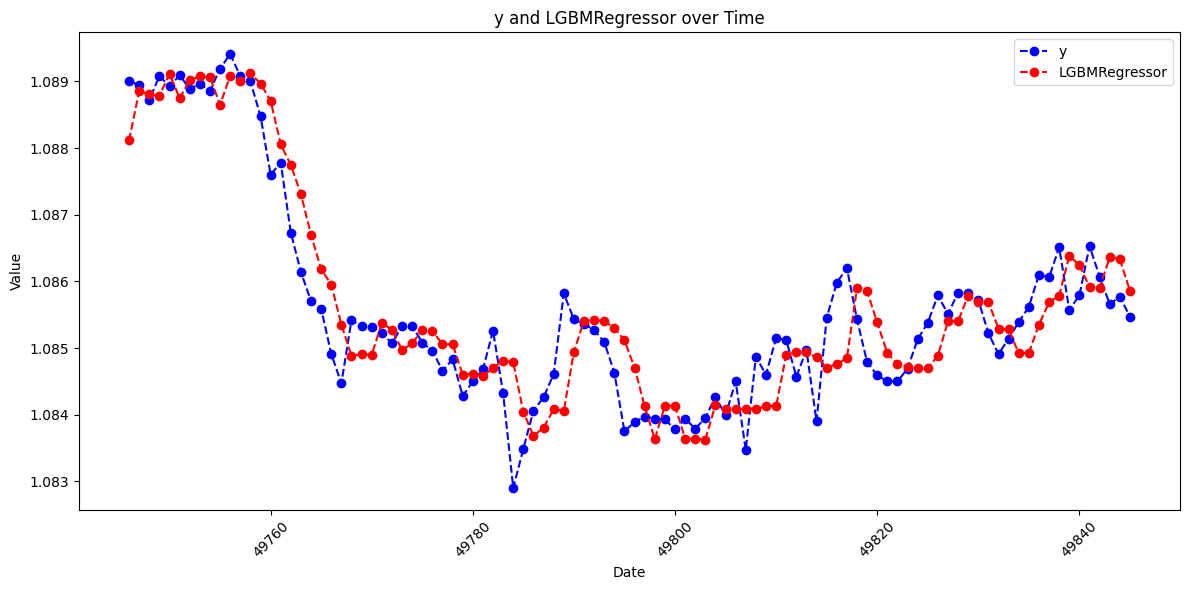

In [97]:
# plot the y and LGBMRegressor predictions on the y-axis, and have the x-axis be 'ds' 
import polars as pl
import matplotlib.pyplot as plt

# Assuming you have already created the cv_df DataFrame
# If not, you'll need to load or create it first

# Convert 'ds' column to datetime if it's not already
# cv_df = cv_df.with_columns(pl.col('ds').cast(pl.Datetime))

# Sort the DataFrame by 'ds' to ensure proper plotting
cv_df = cv_df.sort('ds')

# Convert Polars DataFrame to Pandas for easier plotting
pandas_df = cv_df.to_pandas()

# Create the plot
plt.figure(figsize=(12, 6))
# specify the line to be '-' and the points to be 'o'
plt.plot(pandas_df['ds'], pandas_df['y'], label='y', color='blue', linestyle='--', marker='o')
plt.plot(pandas_df['ds'], pandas_df['LGBMRegressor'], label='LGBMRegressor', color='red', linestyle='--', marker='o')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('y and LGBMRegressor over Time')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()


In [69]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse
cv_rmse = evaluate(
    cv_df.drop('cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)
print(f"RMSE using cross-validation: {cv_rmse['LGBMRegressor'].item()}")


RMSE using cross-validation: 0.0005836514192346573


In [58]:
import lightgbm as lgb
lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}

lgbm_fcst = MLForecast(
    models={
        'avg': lgb.LGBMRegressor(**lgb_params),
        'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq='1h', 
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=3), RollingMean(window_size=6)],
    },
)
lgbm_fcst.fit(train)
preds = lgbm_fcst.predict(10)
fig = plot_series(train, preds, max_insample_length=48)
fig

MLForecast(models=[avg, q75, q25], freq=1h, lag_features=['lag1', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size3', 'rolling_mean_lag24_window_size6'], date_features=[], num_threads=1)